<a href="https://colab.research.google.com/github/polrgn/biomedical_clustering_topic_modeling/blob/main/2a_LDA_TF_IDF_individual_rep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries and data

In [ ]:
import numpy as np 
import random
import pandas as pd
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
import scipy.sparse
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, pairwise
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora

from sklearn.decomposition import LatentDirichletAllocation
from time import time

Mount Google drive

In [ ]:
# Mounting Google drive where we save our data and embeddings
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Features extraction - Representation learning

Load our clean dataset

In [ ]:
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang_abstrlen.csv',index_col=0)
abstract_df = abstract_df[0:10000]

## TF-IDF

Function to get the TF IDF features matrix with $d$ features, considering unigram, bigrams and trigrams.

In [ ]:
def get_tfidf_rep(X,dim):
  print('Features set dimension',d)
  vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features = dim)
  tf_idf_vectorizer = vectorizer.fit(abstract_df.abstract)
  tf_idf_matrix = vectorizer.transform(abstract_df.abstract)

  tf_idf_feature_names = pd.DataFrame({'feature':vectorizer.get_feature_names()})
  print('Sample of feature names', random.sample(tf_idf_feature_names['feature'].to_list(), 20))
  tfidf_array = np.squeeze(np.asarray(tf_idf_matrix.todense()))
  print('Sparsity TF-IDF',sum(sum(tfidf_array==0))/(np.shape(tfidf_array)[0]*np.shape(tfidf_array)[1]))

  return(tfidf_array)

Function to compute the performance metrics of k-means clustering for a given set $v$ of number of clusters. 

In [ ]:
def sv_clustering(X,range_k):
  silhouette = []
  ch = []
  db = []
  for k in range_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=10,
                         init_size=1000, batch_size=1000)
    cluster_labels = km.fit_predict(X)
    silhouette.append(metrics.silhouette_score(X, cluster_labels))
    ch.append(metrics.calinski_harabasz_score(X, cluster_labels))
    db.append(metrics.davies_bouldin_score(X, cluster_labels))

  results = pd.DataFrame({'n_cluster':range_k,'silhouette':silhouette,
                          'CH_score':ch, 'DB_score':db})
  print(results)
  return(results)


Compute performance metrics on clustering. Given our completely unsupervised setting, we use metrics that do not require ground truth labels: Silhouette, Calinski Harabasz, Davies Bouldin

In [ ]:
range_dim = [1000,3000,5000,8000,10000]
range_n_clusters = [5,10,15,20,30]
results = pd.DataFrame()
for d in range_dim:
  tfidf_rep = get_tfidf_rep(abstract_df,d)
  temp = sv_clustering(tfidf_rep,range_n_clusters)
  temp['dimension'] = [d,d,d,d,d]

  results = pd.concat([results,temp], axis = 0)

Features set dimension 1000
Sample of feature names ['dna', 'terms', 'emergence', 'adults', 'technique', 'free', 'united states', 'mass', 'late', 'pubmed', 'chain reaction', 'small', 'invasive', 'established', 'duration', 'proportion', 'rapidly', 'incidence', 'form', 'pressure']
Sparsity TF-IDF 0.9629357
   n_cluster  silhouette   CH_score  DB_score
0          5    0.008959  57.578247  9.480892
1         10    0.008320  39.660868  8.626373
2         15    0.013832  37.907638  7.131391
3         20    0.013749  32.098851  7.113277
4         30    0.017705  28.472234  6.326218
Features set dimension 3000
Sample of feature names ['enhance', 'assigned', 'markedly', 'face', 'healing', 'error', 'contributions', 'nationwide', 'vectors', 'race', 'wide range', 'matched', 'years old', 'focuses', 'normal', 'diagnostic', 'reduces', 'ratios', 'included', 'plant']
Sparsity TF-IDF 0.9817278
   n_cluster  silhouette   CH_score   DB_score
0          5    0.005845  36.423694  12.772614
1         10    0

Heatmap of silhouette score in function of TF-IDF dimension and number of clusters

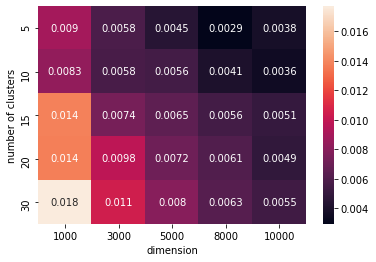

In [ ]:
metric_score = results.pivot("n_cluster", "dimension", "silhouette")
ax = sns.heatmap(metric_score,annot=True)
ax.set(ylabel='number of clusters')
ax.get_figure().savefig("drive/MyDrive/Projet MedML/Images/tfidf_rep_learning_silhouette.png")

Heatmap of Calinski Harabasz score in function of TF-IDF dimension and number of clusters

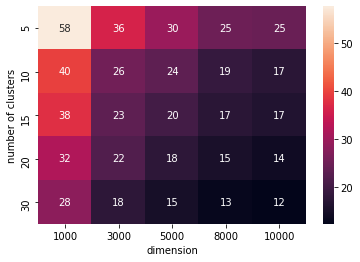

In [ ]:
metric_score = results.pivot("n_cluster", "dimension", "CH_score")
ax = sns.heatmap(metric_score,annot=True)
ax.set(ylabel='number of clusters')
ax.get_figure().savefig("drive/MyDrive/Projet MedML/Images/tfidf_rep_learning_chscore.png")

Heatmap of Davies Bouldin score in function of TF-IDF dimension and number of clusters

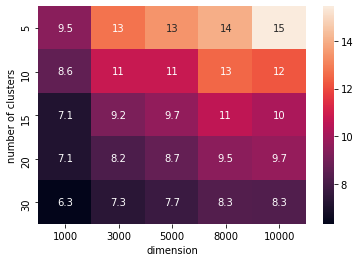

In [ ]:
metric_score = results.pivot("n_cluster", "dimension", "DB_score")
ax = sns.heatmap(metric_score,annot=True)
ax.set(ylabel='number of clusters')
ax.get_figure().savefig("drive/MyDrive/Projet MedML/Images/tfidf_rep_learning_dbscore.png")

Save the TF-IDF features matrix.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features = 5000)
tf_idf_vectorizer = vectorizer.fit(abstract_df.abstract)
tf_idf_matrix = vectorizer.transform(abstract_df.abstract)
scipy.sparse.save_npz('drive/MyDrive/Projet MedML/Outputs/tfidf_abstract', tf_idf_matrix)
pickle.dump(tf_idf_vectorizer, open("drive/MyDrive/Projet MedML/Outputs/tfidf_vectorizer.pickle", "wb"))


## Latent Dirichlet Allocation

We use Gensim LDA function to compute coherence metrics and decide on a number of LDA topics.

We pre process our data for Gensim LDA function 

In [ ]:
# Break abstracts into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(abstract_df.abstract))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(data_words_bigrams)

# Create a corpus from a list of texts
common_dictionary = Dictionary(data_words_trigrams)

common_corpus = [common_dictionary.doc2bow(text) for text in data_words_trigrams]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


We fit a LDA model with different values for the number of topics and compute coherence metrics.

In [ ]:
range_num_topics = [3,4,6,8,10,12,15,20,30]

umass_vec = []
cuci_vec = []
cnpmi_vec = []
cv_vec = []
perplex_vec = []
for k in range_num_topics:
  # Train the model on the corpus.
  lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics=k, id2word=common_dictionary)
  umass = CoherenceModel(model=lda, corpus=common_corpus, coherence='u_mass').get_coherence() 
  cv = CoherenceModel(model=lda, texts=data_words_trigrams, dictionary=common_dictionary, coherence='c_v').get_coherence() 
  cuci = CoherenceModel(model=lda, texts=data_words_trigrams, dictionary=common_dictionary, coherence='c_uci').get_coherence() 
  cnpmi = CoherenceModel(model=lda, texts=data_words_trigrams, dictionary=common_dictionary, coherence = 'c_npmi').get_coherence()  # get coherence value
  
  perplex_vec.append(lda.log_perplexity(common_corpus))
  umass_vec.append(umass)
  cv_vec.append(cv)
  cuci_vec.append(cuci)
  cnpmi_vec.append(cnpmi)

results = pd.DataFrame({'UMass':umass_vec,
                        'CV': cv_vec,
                        'UCI':cuci_vec,
                        'NPMI':cnpmi_vec,
                        'Perplexity': perplex_vec})
print('\nCoherence Score: ', results)
results.to_csv('drive/MyDrive/Projet MedML/Outputs/lda_optim_nb_topics.csv')


Coherence Score:        UMass        CV       UCI      NPMI  Perplexity
0 -2.161710  0.475972  0.166462  0.024376   -8.925852
1 -2.343608  0.392415 -0.038948  0.017312   -8.987344
2 -2.489478  0.438914 -0.080810  0.021175   -8.987550
3 -2.326932  0.480984  0.067376  0.033145   -9.049199
4 -2.339222  0.522928  0.232356  0.044125   -9.058585
5 -2.467086  0.485472  0.035944  0.034674   -9.085404
6 -2.778588  0.476053 -0.238679  0.022577   -9.191236
7 -3.536465  0.472097 -0.964116 -0.003604   -9.245480
8 -3.675062  0.440724 -1.299721 -0.016405   -9.385910


In [ ]:
results = pd.DataFrame({'NumberTopics': range_num_topics,
                        'UMass':umass_vec,
                        'CV': cv_vec,
                        'UCI':cuci_vec,
                        'NPMI':cnpmi_vec,
                        'Perplexity': perplex_vec})
print('\nCoherence Score: ', results)
results.to_csv('drive/MyDrive/Projet MedML/Outputs/lda_optim_nb_topics.csv')


Coherence Score:     NumberTopics     UMass        CV       UCI      NPMI  Perplexity
0             3 -2.161710  0.475972  0.166462  0.024376   -8.925852
1             4 -2.343608  0.392415 -0.038948  0.017312   -8.987344
2             6 -2.489478  0.438914 -0.080810  0.021175   -8.987550
3             8 -2.326932  0.480984  0.067376  0.033145   -9.049199
4            10 -2.339222  0.522928  0.232356  0.044125   -9.058585
5            12 -2.467086  0.485472  0.035944  0.034674   -9.085404
6            15 -2.778588  0.476053 -0.238679  0.022577   -9.191236
7            20 -3.536465  0.472097 -0.964116 -0.003604   -9.245480
8            30 -3.675062  0.440724 -1.299721 -0.016405   -9.385910


We fit a LDA with scikit-learn function with 10 topics. We first need to compute the term frequency document-matrix.

In [ ]:
countvectorizer = CountVectorizer(max_features=5000)
data_vectorized = countvectorizer.fit_transform(abstract_df.abstract)
pickle.dump(countvectorizer, open("drive/MyDrive/Projet MedML/Outputs/lda_countvectorizer.pickle", "wb"))

In [ ]:
lda = LatentDirichletAllocation(n_components=10,
                                learning_method='online',
                                random_state=0)
t0 = time()
lda.fit(data_vectorized)
print("done in %0.3fs." % (time() - t0))

joblib.dump(lda, 'drive/MyDrive/Projet MedML/Outputs/lda_model.jl')

done in 40.029s.


['drive/MyDrive/Projet MedML/Outputs/lda_model.jl']

In [ ]:
#Reload LDA model
lda_model = joblib.load('drive/MyDrive/Projet MedML/Outputs/lda_model.jl')
array_doc_topic_dist =lda_model.transform(data_vectorized)
print(np.shape(array_doc_topic_dist))
array_doc_topic_dist[0:5,0:5]
doc_topic_dist = pd.concat((abstract_df,pd.DataFrame(array_doc_topic_dist,index=abstract_df.index.values)),axis=1)
doc_topic_dist.to_csv('drive/MyDrive/Projet MedML//Outputs/lda_abstract_df.csv')

(10000, 10)


We plot topics top words

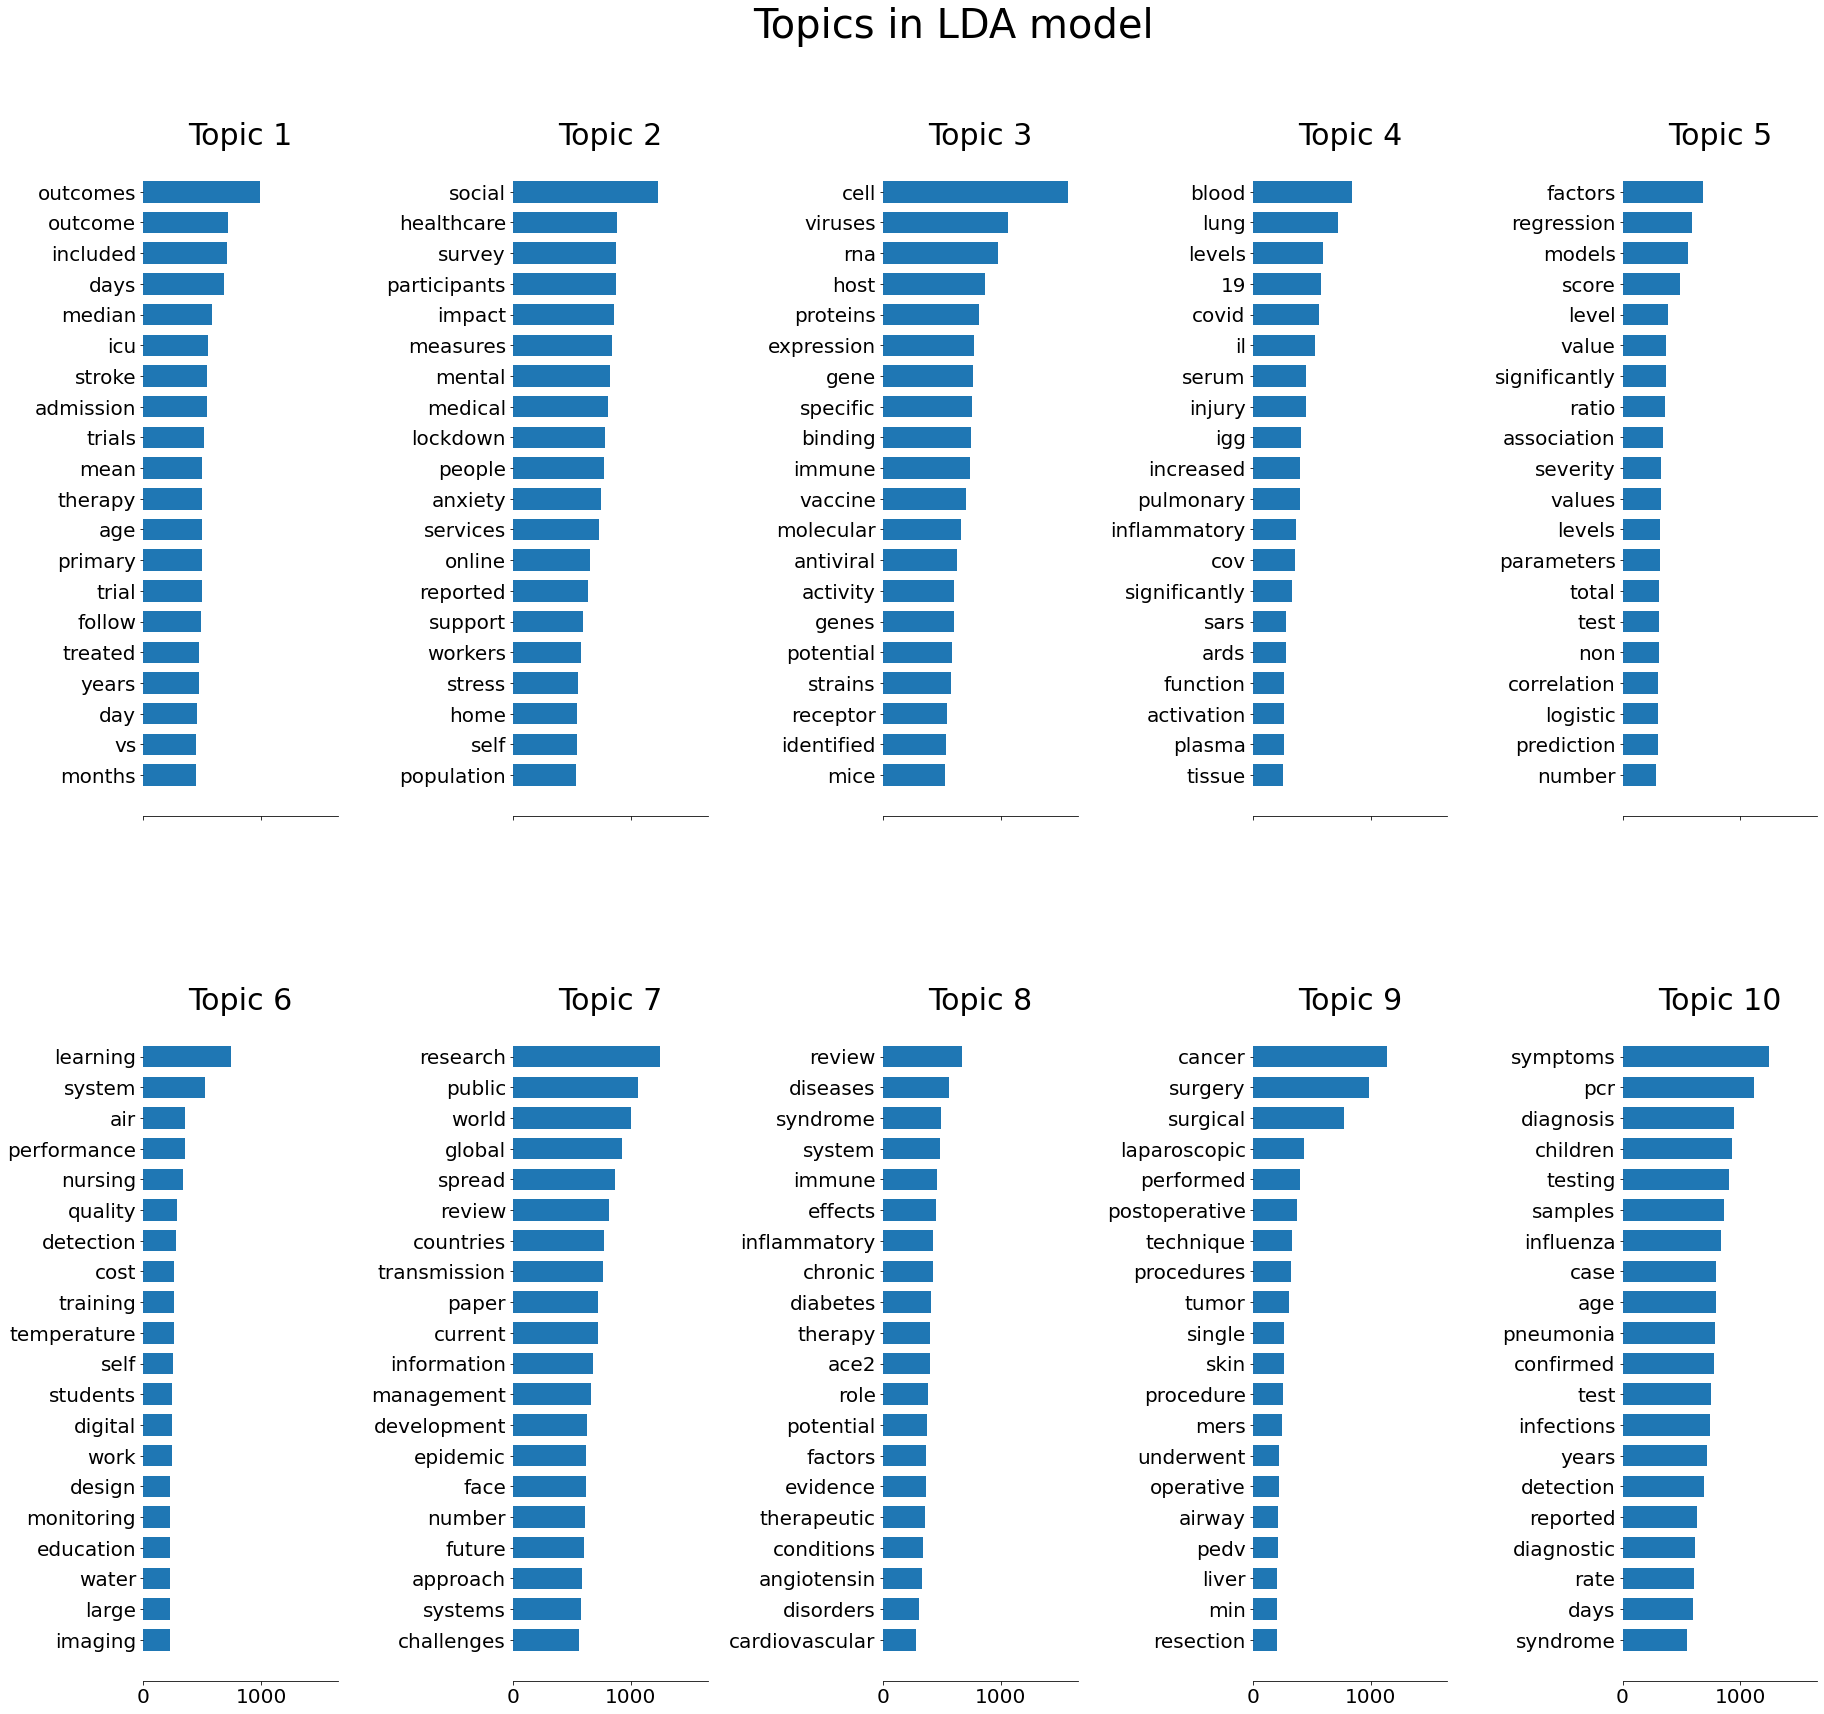

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    if len(model.components_)% 5 ==0:
      nlines = int(len(model.components_)/5)
    else:
        nlines = int(round(len(model.components_)/5) +1)
    fig, axes = plt.subplots(nlines, 5, figsize=(30, 25), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    plt.savefig('drive/MyDrive/Projet MedML/Images/topics_lda.png')

tf_feature_names = countvectorizer.get_feature_names()
n_top_words = 20
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

Save the found topics.

In [ ]:
def topics_df(model, feature_names, n_top_words):
    topic_str = []
    topic_str_toprint =[]
    weights_array = np.empty(shape=(len(model.components_),n_top_words))
    i = 0
    for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            topic_str.append(' '.join(top_features))
            topic_str_toprint.append(', '.join(top_features))
            weights_array[i,:] = weights
            i += 1
    topics_df = pd.DataFrame(weights_array)
    topics_df['topic'] = topic_str
    topics_df['topic_toprint'] = topic_str_toprint
    print(topics_df)
    return(topics_df)


topics_df(lda, tf_feature_names, n_top_words = 15).to_csv('drive/MyDrive/Projet MedML/Outputs/topics_lda_df.csv')

             0  ...                                      topic_toprint
0   988.646840  ...  outcomes, outcome, included, days, median, icu...
1  1232.812857  ...  social, healthcare, survey, participants, impa...
2  1572.049128  ...  cell, viruses, rna, host, proteins, expression...
3   841.161360  ...  blood, lung, levels, 19, covid, il, serum, inj...
4   682.192668  ...  factors, regression, models, score, level, val...
5   741.792260  ...  learning, system, air, performance, nursing, q...
6  1247.604140  ...  research, public, world, global, spread, revie...
7   667.231000  ...  review, diseases, syndrome, system, immune, ef...
8  1135.239869  ...  cancer, surgery, surgical, laparoscopic, perfo...
9  1243.807897  ...  symptoms, pcr, diagnosis, children, testing, s...

[10 rows x 17 columns]
